In [1]:
from lavis.datasets.builders import load_dataset
from lavis.models import load_model_and_preprocess
from dotenv import load_dotenv
from PIL import Image
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    DCT,
    TOFU,
    LTMP,
    NONE, 
    pitome,
    tome,
    DiffRate,
    tofu,
    # ltmp
)

FLICKR_PATH='/media/caduser/MyBook/chau/.cache/flickr30k/images'
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
dataset = load_dataset("flickr30k", vis_path=FLICKR_PATH, cfg_path=None)


Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/train.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/val.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/test.json


In [2]:
dataset

{'train': <lavis.datasets.datasets.retrieval_datasets.RetrievalDataset at 0x7f21e1c69f10>,
 'val': <lavis.datasets.datasets.retrieval_datasets.RetrievalEvalDataset at 0x7f205c045450>,
 'test': <lavis.datasets.datasets.retrieval_datasets.RetrievalEvalDataset at 0x7f205be83890>}

In [3]:

from lavis.processors.base_processor import BaseProcessor
from lavis.processors.randaugment import RandomAugment
from omegaconf import OmegaConf
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from lavis.processors.blip_processors import BlipImageBaseProcessor

img = dataset['train'][0]['image']
img_input = vis_processors['eval'](img)
# img 

In [4]:
from main_vl import (
    PITOME,
    TOME, 
    TOFU, 
    DIFFRATE, 
)

def get_model(model, algo, ratio):
    if algo == PITOME:
        pitome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        pitome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOME:
        tome.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        tome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOFU:
        tofu.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        tofu.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == DIFFRATE:
        DiffRate.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        DiffRate.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.init_kept_num_using_ratio(ratio)
        model.visual_encoder_m.init_kept_num_using_ratio(ratio)


get_model(model,PITOME, 0.9)

model 

using pitome
using pitome


BlipRetrieval(
  (visual_encoder): PiToMeVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x PiToMeBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=Fa

In [5]:
class BlipImageEvalProcessor(BlipImageBaseProcessor):
    def __init__(self, image_size=384, mean=None, std=None):
        super().__init__(mean=mean, std=std)

      
        transform_list = [
            transforms.Resize(
                (image_size, image_size), interpolation=InterpolationMode.BICUBIC
            ),
        ]

        # The visualization and model need different transforms
        self.transform_vis  = transforms.Compose(transform_list)
        self.transform = transforms.Compose(transform_list + [
            transforms.ToTensor(),
            self.normalize,
        ])

    def __call__(self, item):
        return self.transform_vis(item), self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 384)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)

processor = BlipImageEvalProcessor() 
img_vis, img_input = processor(img)

model.visual_encoder(img_input[None,...])

tensor([[[ 1.0879,  0.6764, -0.8212,  ..., -0.9351, -0.7611, -0.6236],
         [ 0.5859, -0.7970, -0.0567,  ..., -0.0636, -0.2672, -0.0635],
         [-0.4071, -0.4174, -0.4241,  ...,  0.0164,  0.3163, -0.4389],
         ...,
         [ 0.2687, -0.0155, -0.0849,  ..., -0.1346, -0.0079, -0.6976],
         [-0.4349, -0.2339, -0.4489,  ...,  0.8445,  0.7293, -0.3285],
         [ 0.3359, -0.2709, -0.4318,  ...,  0.6753, -0.0482, -0.2765]]],
       grad_fn=<NativeLayerNormBackward0>)

In [6]:

attn = model.visual_encoder.blocks[-1].attn.attention_map
attn.shape

torch.Size([1, 12, 184, 184])

In [8]:
source = model.visual_encoder._tome_info['source']

print(source.shape)
# pitome.make_visualization(img_vis, source, attn.sum(1)[:, 0, :],patch_size=16, class_token=True)

torch.Size([1, 184, 577])


In [22]:
import random
from typing import List, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

try:
    from scipy.ndimage import binary_erosion
except ImportError:
    pass  # Don't fail if scipy is not installed. It's only necessary for this one file.


def generate_colormap(N: int, attention_score: torch.Tensor, seed: int = 0) -> List[Tuple[float, float, float]]:
  """
  Generates a colormap with N elements, with a bolder blue base and lightness adjusted based on attention scores.

  Args:
      N: Number of colors to generate.
      attention_score: A torch.Tensor representing the attention scores.
          This will be used to modulate the lightness of the blue color.
      seed: An optional integer seed for reproducibility.

  Returns:
      A list of tuples representing RGB color values (0.0 to 1.0).
  """



  def adjust_lightness(attention_value):
    normalized_attention = (attention_value - attention_score.min()) / (attention_score.max() - attention_score.min())
    lightness_adjustment =  normalized_attention  # Adjust factor for lightness range
    base = (1.0, 1.0, 1.0)
    adjusted_color = [base[0], base[1], base[2] + lightness_adjustment]
    return tuple(max(0.0, min(1.0, val)) for val in adjusted_color)

  colormap = [adjust_lightness(attention_value) for attention_value in attention_score.flatten().tolist()]

  return colormap


def make_visualization(
    img: Image, source: torch.Tensor, attention_score:torch.Tensor, patch_size: int = 16, class_token: bool = True
) -> Image:
    """
    Create a visualization like in the paper.

    Args:
     -

    Returns:
     - A PIL image the same size as the input.
    """

    img = np.array(img.convert("RGB")) / 255.0
    source = source.detach().cpu()

    h, w, _ = img.shape
    ph = h // patch_size
    pw = w // patch_size

    if class_token:
        source = source[:, :, 1:]
    vis = source.argmax(dim=1)
    num_groups = vis.max().item() + 1
    print('num_group',num_groups)

    cmap = generate_colormap(num_groups, attention_score)
    vis_img = 0

    for i in range(num_groups):
        mask = (vis == i).float().view(1, 1, ph, pw)
        mask = F.interpolate(mask, size=(h, w), mode="nearest")
        mask = mask.view(h, w, 1).numpy()

        color = (mask * img).sum(axis=(0, 1)) / mask.sum()
        mask_eroded = binary_erosion(mask[..., 0])[..., None]
        mask_edge = mask - mask_eroded

        if not np.isfinite(color).all():
            color = np.zeros(3)

        vis_img = vis_img + mask_eroded * color.reshape(1, 1, 3)
        vis_img = vis_img + mask_edge * np.array(cmap[i]).reshape(1, 1, 3)

    # Convert back into a PIL image
    vis_img = Image.fromarray(np.uint8(vis_img * 255))

    return vis_img


num_group 184


/tmp/ipykernel_61045/2761749506.py:76: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


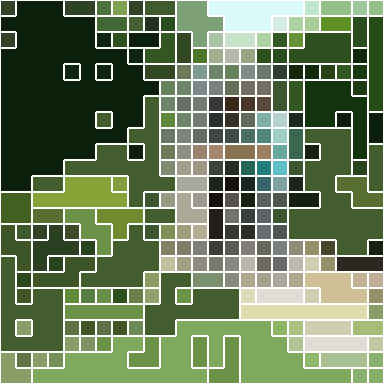

In [23]:
make_visualization(img_vis, source, attn.sum(1)[:, 0, :], patch_size=16, class_token=True)